In [1]:
from roi import equity, external, utilities, macro, metrics, cost, surveys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# make figures readable by humans instead of mice
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

In [2]:
bls_api_key = "c8803d0ba66c4592b8b0eff68ac9ebb0"

In [3]:
data = pd.read_csv("testing/testing-data/test_microdata_2.csv")

In [4]:
programs = pd.read_csv("testing/testing-data/programs.csv")

In [5]:
data.columns

Index(['Unnamed: 0', 'race', 'gender', 'earnings_start', 'earnings_end', 'age',
       'program', 'program_start', 'program_end', 'education_level',
       'completer', 'employed_at_end', 'employed_at_start', 'state',
       'full_address', 'Address', 'City', 'State', 'Zip', 'id', 'start_month',
       'end_month'],
      dtype='object')

__Equity analysis__

In [6]:
gini = equity.Gini.from_dataframe(data, 'gender', 'earnings_end', sample = 2000)
gini.calculate()

/Users/mattlerner/roi/sbir-roi/roi/equity.py:77: UserWarning: When sample == True, Metric() will use the value of sample to create a random subset of values that it will use for all calculations. This number will be stored as attribute .samplesize.
  warnings.warn("When sample == True, Metric() will use the value of sample to create a random subset of values that it will use for all calculations. This number will be stored as attribute .samplesize.")
/Users/mattlerner/roi/sbir-roi/roi/equity.py:61: UserWarning: Data passed contains 92 NA values. All equity metrics are calculated by ignoring NA values, in effect dropping them. Please ensure that you have a strategy for dealing with these missing values. If values are not missing at random, e.g. if individuals with missing values have common traits, then ALL METRICS calculated will be biased.
  warnings.warn("Data passed contains {} NA values. All equity metrics are calculated by ignoring NA values, in effect dropping them. Please ensure

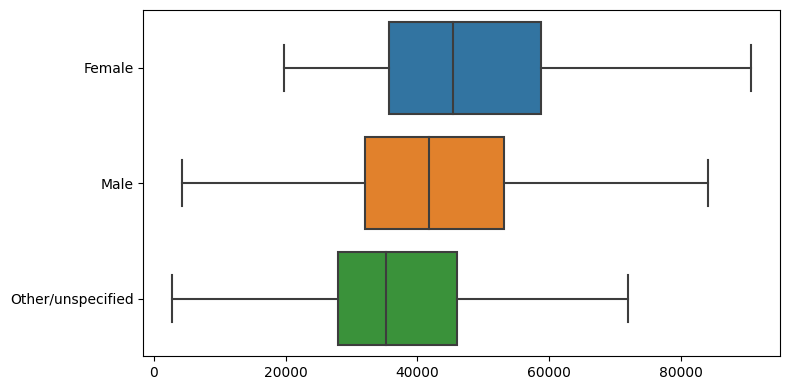

In [7]:
gini.viz

In [8]:
gini.ratio

0.3255329064790096

In [9]:
gini.sample

2000

__Geocode addresses__

In [10]:
small_data = data.sample(30)

In [11]:
small_data.head()

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,employed_at_start,state,full_address,Address,City,State,Zip,id,start_month,end_month
10786,10787,Other,Male,27383.000,nan,50,Philosophy,2012,2016,111,...,1,8,1605 EAST DEL MAR STE 103 LAREDO TX 78041,1605 EAST DEL MAR STE 103,LAREDO,TX,78041.000,12502,10,5
5397,5398,Other,Male,29221.000,nan,23,Philosophy,2015,2017,73,...,1,8,NaN,NaN,NaN,NaN,nan,13152,8,7
9954,9955,Asian or Pacific Islander,Male,31261.000,36554.400,49,Anthropology,2019,2021,111,...,1,8,NaN,NaN,NaN,NaN,nan,8914,9,7
11956,11957,Asian or Pacific Islander,Other/unspecified,29550.000,25699.240,18,Anthropology,2012,2014,123,...,0,8,"375 LAGUNA HONDA BLVD, UNIT F5 SAN FRANCISCO C...","375 LAGUNA HONDA BLVD, UNIT F5",SAN FRANCISCO,CA,94116.000,4780,8,6
3728,3729,Other,Other/unspecified,36674.000,46908.780,18,Philosophy,2012,2015,60,...,1,8,"9290 WEST DODGE ROAD, SUITE 201A OMAHA NE 68114","9290 WEST DODGE ROAD, SUITE 201A",OMAHA,NE,68114.000,9310,9,5


In [12]:
small_data['geocode'] = external.Census.get_batch_geocode(small_data)

Successfully geocoded 40.0% of 30 passed addresses.
Of successfully matched addresses, 66.67% were exact matches


__Get SES for each individual with a geocode__

In [13]:
adi = equity.ADI()

In [14]:
small_data['ses'] = adi.get_quintile_for_geocodes_frame(small_data, 'geocode')

Geocode merge: Merged 12 of 30 observations in input dataframe (40.0%)


In [15]:
small_data.head()

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,full_address,Address,City,State,Zip,id,start_month,end_month,geocode,ses
10786,10787,Other,Male,27383.000,nan,50,Philosophy,2012,2016,111,...,1605 EAST DEL MAR STE 103 LAREDO TX 78041,1605 EAST DEL MAR STE 103,LAREDO,TX,78041.000,12502,10,5,,NaN
5397,5398,Other,Male,29221.000,nan,23,Philosophy,2015,2017,73,...,NaN,NaN,NaN,NaN,nan,13152,8,7,,NaN
9954,9955,Asian or Pacific Islander,Male,31261.000,36554.400,49,Anthropology,2019,2021,111,...,NaN,NaN,NaN,NaN,nan,8914,9,7,,NaN
11956,11957,Asian or Pacific Islander,Other/unspecified,29550.000,25699.240,18,Anthropology,2012,2014,123,...,"375 LAGUNA HONDA BLVD, UNIT F5 SAN FRANCISCO C...","375 LAGUNA HONDA BLVD, UNIT F5",SAN FRANCISCO,CA,94116.000,4780,8,6,060750305003,NaN
3728,3729,Other,Other/unspecified,36674.000,46908.780,18,Philosophy,2012,2015,60,...,"9290 WEST DODGE ROAD, SUITE 201A OMAHA NE 68114","9290 WEST DODGE ROAD, SUITE 201A",OMAHA,NE,68114.000,9310,9,5,310550066025,80-100


__Check out SES equity concerns__

In [16]:
theil_t = equity.Theil_T.from_dataframe(small_data, 'ses', 'earnings_end')

In [17]:
theil_t.calculate()

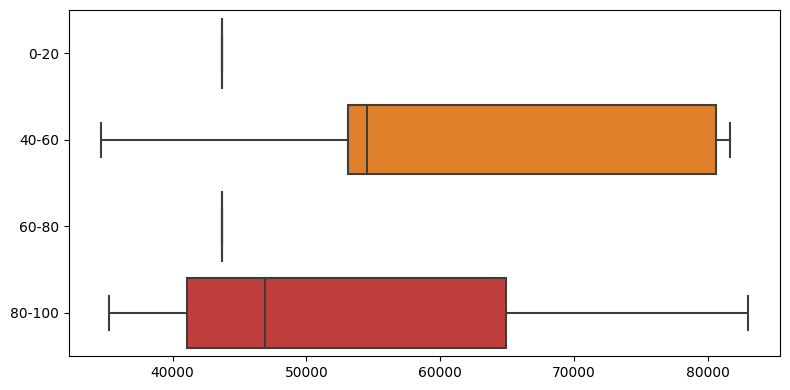

In [18]:
theil_t.viz

In [19]:
theil_t.ratio

0.14020212293944603

__Calculate graduate wage summary statistics__

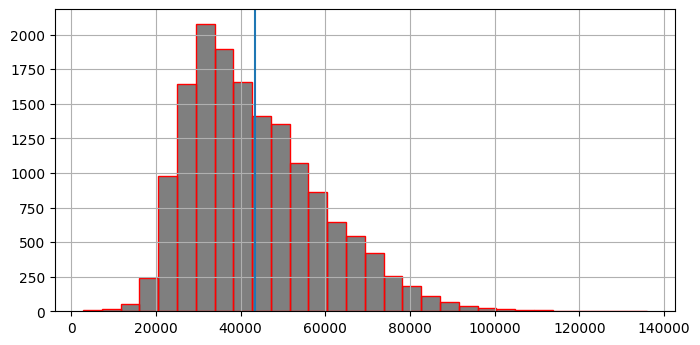

In [20]:
fig, ax = plt.subplots()
data['earnings_end'].hist(ax=ax, edgecolor="red", fc=(0, 0, 0, 0.5), bins=30)
plt.axvline(x=np.mean(data['earnings_end']))

In [21]:
utilities.multiple_describe(data, 'program', 'earnings_end')

,program,n,mean,median,sd,min,max
0,Anthropology,2288.000,31540.395,31381.600,6542.271,2817.240,63547.440
1,Art History,2370.000,42312.370,41632.800,9460.368,4287.800,75483.430
2,Biology,2404.000,35848.828,35303.220,7838.359,6602.715,64873.710
3,Economics,2327.000,54705.240,54158.720,11048.693,14172.620,102118.940
4,Electrical Engineering,2386.000,65698.580,64849.900,14206.740,20139.900,135887.290
5,French Literature,2339.000,27875.583,27687.748,5501.041,6088.635,50285.620
6,Philosophy,2297.000,46128.218,45486.000,10275.570,14191.200,96564.600


__Adjust wages for inflation__

In [22]:
bls = macro.BLS_Ops()
data['earnings_end_adjusted'] = bls.adjust_to_current_dollars(data, 'program_end', 'earnings_end')

Latest CPI year in provided BLS data is 2018.0: All dollars being adjusted to 2018.0 dollars.
Years in provided dataframe for which there is no data in the provided CPI frame:

{2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028}


/Users/mattlerner/roi/sbir-roi/roi/macro.py:58: UserWarning: Value column earnings_end contains 821 NA values (5.0%) of total.
  warnings.warn("Value column {} contains {} NA values ({}%) of total.".format(value_column_name, value_nas, round(100*value_nas/len(frame_),2)))
/Users/mattlerner/roi/sbir-roi/roi/macro.py:71: UserWarning: 5515 rows in column program_end could not be merged with provided CPI data. Please note that (1) the BLS API provides only up to 20 years of data; if you want to use more, you will have to manually combine multiple queries. (2) We do not recommend using more than ten years of historical data in calculations.
  warnings.warn("{} rows in column {} could not be merged with provided CPI data. Please note that (1) the BLS API provides only up to 20 years of data; if you want to use more, you will have to manually combine multiple queries. (2) We do not recommend using more than ten years of historical data in calculations.".format(unmerged_len, year_column_name))

In [23]:
data[['program_end','earnings_end','earnings_end_adjusted']].sample(10)

,program_end,earnings_end,earnings_end_adjusted
12943,2017,nan,nan
10090,2021,25168.160,nan
8915,2022,56026.800,nan
16058,2017,34689.270,35535.564
13057,2022,36945.700,nan
1921,2018,nan,nan
11415,2018,57415.710,57415.710
820,2015,35727.200,37852.676
11822,2017,34259.280,35095.084
1876,2016,nan,nan


__Recalculate average graduate wage by program__

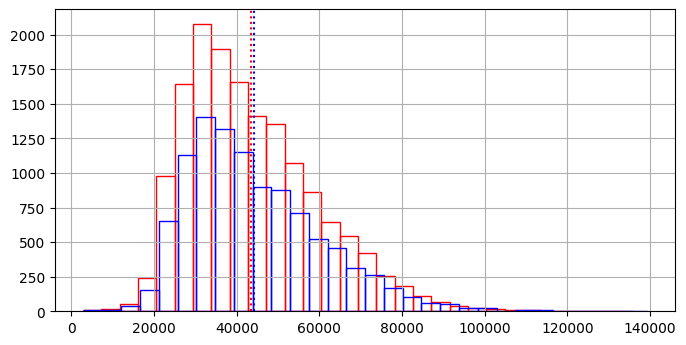

In [24]:
fig, ax = plt.subplots()

# unadjusted
data['earnings_end'].hist(ax=ax, edgecolor="red", fc=(0, 0, 0, 0), bins=30)
plt.axvline(x=np.mean(data['earnings_end']), color="red", linestyle=":")

# adjusted
data['earnings_end_adjusted'].hist(ax=ax, edgecolor="blue", fc=(0, 0, 0, 0), bins=30)
plt.axvline(x=np.mean(data['earnings_end_adjusted']), color="blue", linestyle=":")

__Calculate earnings premium - Simple way__

In [25]:
data['earnings_change'] = data['earnings_end'] - data['earnings_start']

In [26]:
utilities.multiple_describe(data, 'program', 'earnings_change')

,program,n,mean,median,sd,min,max
0,Anthropology,2288.000,1492.413,1748.180,7514.140,-46000.200,41005.440
1,Art History,2370.000,13117.589,13010.150,8743.259,-49156.200,54181.100
2,Biology,2404.000,5538.174,5503.500,7822.369,-28674.700,54911.950
3,Economics,2327.000,24685.001,24170.200,10529.107,-15061.260,77500.780
4,Electrical Engineering,2386.000,36063.777,35277.400,13514.743,-21673.600,112955.900
5,French Literature,2339.000,-2656.493,-2261.950,6824.586,-62843.250,36069.590
6,Philosophy,2297.000,16914.652,16949.000,9296.036,-22386.120,61526.600


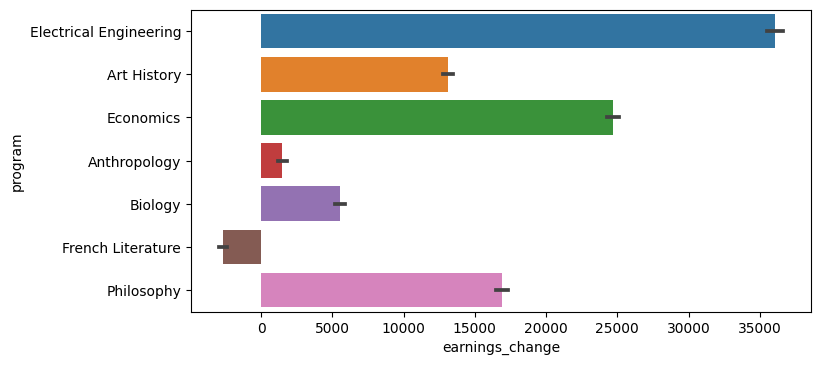

In [27]:
sns.barplot(x="earnings_change", y="program", data=data, estimator=np.mean)

__Calculate earnings premium - Fancy way__

In [28]:
data['year_month_entry'] = data['program_start'].astype(str) + '-' + data['start_month'].astype(str).str.zfill(2)
data['year_month_exit'] = data['program_end'].astype(str) + '-' + data['end_month'].astype(str).str.zfill(2)

In [29]:
data

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,City,State,Zip,id,start_month,end_month,earnings_end_adjusted,earnings_change,year_month_entry,year_month_exit
0,1,White,Male,46027.000,91781.300,25,Electrical Engineering,2014,2016,0,...,REDDING,CA,96001.000,5335,9,6,96031.062,45754.300,2014-09,2016-06
1,2,White,Male,41976.000,66896.700,25,Electrical Engineering,2017,2025,0,...,NaN,NaN,nan,8340,9,6,nan,24920.700,2017-09,2025-06
2,3,White,Male,61396.000,74524.600,51,Electrical Engineering,2014,2019,0,...,AIKEN,SC,29801.000,13875,8,7,nan,13128.600,2014-08,2019-07
3,4,White,Male,34089.000,92032.900,18,Electrical Engineering,2018,2022,0,...,NaN,NaN,nan,1201,9,5,nan,57943.900,2018-09,2022-05
4,5,White,Male,57897.000,79573.600,35,Electrical Engineering,2011,2013,0,...,NEWPORT,OR,97365.000,15397,10,6,85773.314,21676.600,2011-10,2013-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16406,16407,Other,Other/unspecified,32621.000,41195.760,18,Philosophy,2016,2021,125,...,LADY LAKE,FL,32159.000,2180,8,7,nan,8574.760,2016-08,2021-07
16407,16408,Other,Other/unspecified,32994.000,41582.340,43,Philosophy,2015,2019,125,...,SHELDON,IA,51201.000,9786,10,6,nan,8588.340,2015-10,2019-06
16408,16409,Other,Other/unspecified,32316.000,41120.280,43,Philosophy,2017,2023,125,...,NaN,NaN,nan,4966,10,5,nan,8804.280,2017-10,2023-05
16409,16410,Other,Other/unspecified,32697.000,41611.920,38,Philosophy,2016,2018,125,...,NaN,NaN,nan,1139,10,5,41611.920,8914.920,2016-10,2018-05


In [30]:
data['macro_wage_change'] = bls.wage_change(data, 'State','year_month_entry','year_month_exit')

/Users/mattlerner/roi/sbir-roi/roi/macro.py:202: UserWarning: Series passed as argument state_code contains invalid values for state codes. Please refer to https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm for valid codes. Use utilities.State_To_FIPS_series() to convert postal codes to FIPS.
  warnings.warn("Series passed as argument state_code contains invalid values for state codes. Please refer to https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm for valid codes. Use utilities.State_To_FIPS_series() to convert postal codes to FIPS.")


In [31]:
data['State']

0         CA
1        NaN
2         SC
3        NaN
4         OR
        ... 
16406     FL
16407     IA
16408    NaN
16409    NaN
16410    NaN
Name: State, Length: 16411, dtype: object

In [32]:
data['state_fips'] = utilities.State_To_FIPS_series(data['State'])

In [33]:
data[['State','state_fips']]

,State,state_fips
0,CA,06
1,NaN,nan
2,SC,45
3,NaN,nan
4,OR,41
...,...,...
16406,FL,12
16407,IA,19
16408,NaN,nan
16409,NaN,nan


In [34]:
data['macro_wage_change'] = bls.wage_change(data, 'state_fips','year_month_entry','year_month_exit')

/Users/mattlerner/roi/sbir-roi/roi/macro.py:202: UserWarning: Series passed as argument state_code contains invalid values for state codes. Please refer to https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm for valid codes. Use utilities.State_To_FIPS_series() to convert postal codes to FIPS.
  warnings.warn("Series passed as argument state_code contains invalid values for state codes. Please refer to https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm for valid codes. Use utilities.State_To_FIPS_series() to convert postal codes to FIPS.")


In [35]:
data.sample(10)

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,Zip,id,start_month,end_month,earnings_end_adjusted,earnings_change,year_month_entry,year_month_exit,macro_wage_change,state_fips
5795,5796,Other,Other/unspecified,38172.000,65494.625,53,Electrical Engineering,2010,2013,81,...,2865.000,4114,8,7,70597.423,27322.625,2010-08,2013-07,3251.040,44
4975,4976,White,Other/unspecified,34057.000,31140.855,18,Biology,2012,2017,73,...,nan,3013,9,5,31900.580,-2916.145,2012-09,2017-05,nan,nan
4479,4480,Black,Other/unspecified,32861.000,49100.590,18,Economics,2014,2017,73,...,78728.000,3648,10,7,50298.469,16239.590,2014-10,2017-07,2933.840,48
977,978,Asian or Pacific Islander,Female,26964.000,49023.040,39,Anthropology,2014,2015,0,...,92832.000,11693,10,6,51939.510,22059.040,2014-10,2015-06,808.080,06
5707,5708,Other,Female,26486.000,79467.520,55,Electrical Engineering,2013,2019,81,...,74501.000,7578,10,7,nan,52981.520,2013-10,2019-07,6329.960,40
4071,4072,Other,Male,3729.000,4287.800,38,Art History,2014,2016,73,...,nan,12065,8,7,4486.339,558.800,2014-08,2016-07,nan,nan
6833,6834,Black,Male,24347.000,22942.500,18,French Literature,2013,2016,81,...,91204.000,14503,10,6,24004.810,-1404.500,2013-10,2016-06,3091.920,06
705,706,Black,Other/unspecified,27394.000,55133.890,30,Economics,2011,2016,0,...,80215.000,11445,8,6,57686.762,27739.890,2011-08,2016-06,4535.960,08
16275,16276,Black,Female,33413.000,59150.520,36,Philosophy,2012,2015,125,...,25302.000,12075,8,7,62669.492,25737.520,2012-08,2015-07,2553.720,54
9936,9937,Black,Male,25607.000,31323.200,43,Anthropology,2016,2022,111,...,33771.000,14451,10,7,nan,5716.200,2016-10,2022-07,nan,12


In [36]:
data['trend_adjusted_change'] = data['earnings_change'] - data['macro_wage_change']

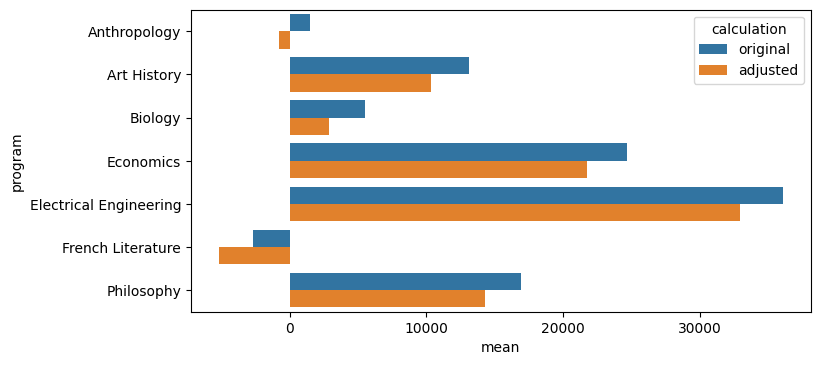

In [37]:
# ignore this ugly cod
original_summary = utilities.multiple_describe(data, 'program', 'earnings_change')
adjusted_summary = utilities.multiple_describe(data, 'program', 'trend_adjusted_change')
original_summary['calculation'] = "original"
adjusted_summary['calculation'] = "adjusted"

sns.barplot(x="mean", y="program", hue="calculation", data=pd.concat([original_summary, adjusted_summary]))

__Calculate earnings premium - VERY fancy way__

In [38]:
premium = metrics.Earnings_Premium(data, 'state_fips', 'education_level', 'earnings_start', 'earnings_end', 'program_start', 'program_end', 'age')

/Users/mattlerner/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [39]:
data['predicted_wage'] = premium.predicted_wage
data['earnings_premium'] = premium.full_premium

In [40]:
data.sample(5)

,Unnamed: 0,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,end_month,earnings_end_adjusted,earnings_change,year_month_entry,year_month_exit,macro_wage_change,state_fips,trend_adjusted_change,predicted_wage,earnings_premium
9263,9264,Asian or Pacific Islander,Female,43490.000,109133.200,38,Electrical Engineering,2015,2019,111,...,6,nan,65643.200,2015-08,2019-06,2958.280,48,62684.920,50463.199,58670.001
7157,7158,White,Female,33838.000,58093.200,27,Philosophy,2012,2016,81,...,7,60783.097,24255.200,2012-09,2016-07,2709.200,06,21546.000,45789.896,12303.304
11564,11565,Other,Male,26910.000,50457.400,25,Economics,2015,2024,123,...,7,nan,23547.400,2015-10,2024-07,nan,nan,nan,50544.811,-87.411
422,423,Asian or Pacific Islander,Female,25734.000,nan,20,Art History,2019,2020,0,...,5,nan,nan,2019-08,2020-05,nan,48,nan,28794.059,nan
8663,8664,White,Male,15885.000,nan,40,French Literature,2013,2017,92,...,7,nan,nan,2013-09,2017-07,nan,nan,nan,18338.049,nan


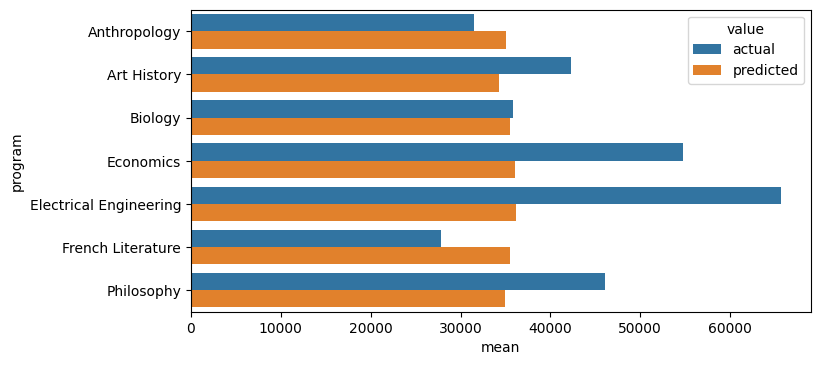

In [41]:
# Mean predicted vs actual wage by program
original_summary = utilities.multiple_describe(data, 'program', 'earnings_end')
adjusted_summary = utilities.multiple_describe(data, 'program', 'predicted_wage')
original_summary['value'] = "actual"
adjusted_summary['value'] = "predicted"

sns.barplot(x="mean", y="program", hue="value", data=pd.concat([original_summary, adjusted_summary]))

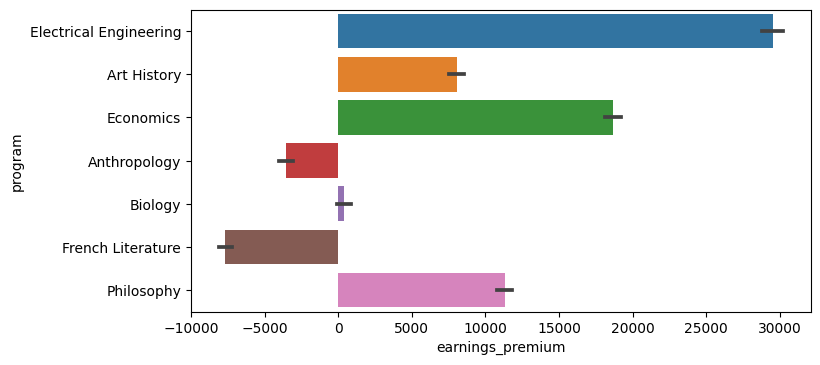

In [42]:
sns.barplot(x="earnings_premium", y="program", data=data, estimator=np.mean)

__Calculate employment premium__

In [65]:
employment = metrics.Employment_Likelihood(data, 'program', 'year_month_entry', 'year_month_exit', 'employed_at_end', 'employed_at_start', 'state')

In [67]:
premium = employment.employment_premium

Text(0.5, 1.0, 'Average employment premium')

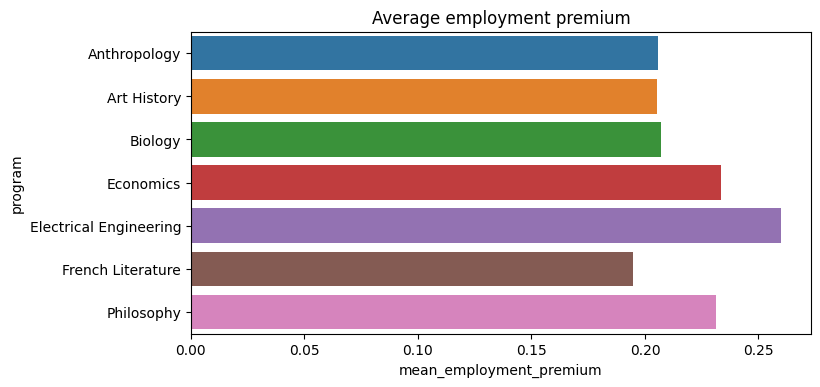

In [70]:
sns.barplot(x="mean_employment_premium", y="program", data=premium).set_title("Average employment premium")

__Calculate time to completion and completion rate statistics__

In [46]:
completion = metrics.Completion(data, 'program', 'program_start', 'program_end', 'completer')

In [47]:
completion_time = completion.time_to_completion
completion_time

,program,n,mean,median,sd,min,max
0,Anthropology,2288,3.101,3,1.764,-1,10
1,Art History,2370,3.361,3,1.711,0,10
2,Biology,2404,3.192,3,1.725,-1,11
3,Economics,2327,3.713,3,1.792,0,12
4,Electrical Engineering,2386,4.009,4,1.732,0,11
5,French Literature,2339,3.041,3,1.709,-1,10
6,Philosophy,2297,3.527,3,1.713,0,11


In [48]:
completion_rate = completion.completion_rates
completion_rate

,program,n,mean,median,sd,min,max
0,Anthropology,2288,0.669,1,0.471,0,1
1,Art History,2370,0.682,1,0.466,0,1
2,Biology,2404,0.671,1,0.470,0,1
3,Economics,2327,0.634,1,0.482,0,1
4,Electrical Engineering,2386,0.592,1,0.492,0,1
5,French Literature,2339,0.702,1,0.458,0,1
6,Philosophy,2297,0.654,1,0.476,0,1


Text(0.5, 1.0, 'Average time to complete')

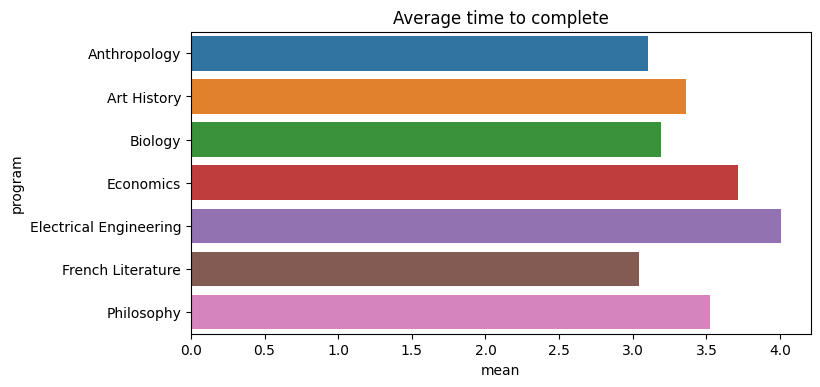

In [49]:
sns.barplot(x="mean", y="program", data=completion_time).set_title("Average time to complete")

Text(0.5, 1.0, 'Average completion rate')

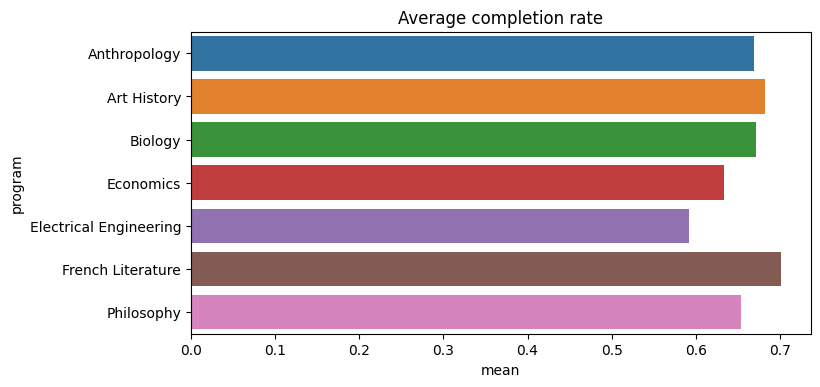

In [50]:
sns.barplot(x="mean", y="program", data=completion_rate).set_title("Average completion rate")

__Try out loan amounts__

In [51]:
data_programs = data.merge(programs, left_on="program", right_on="programs", how="left")
data_programs['total_cost'] = data_programs['cost_per_semester'] * data_programs['length']
data_programs['period_payment'] = cost.Compound_Interest_Loan.calculate_period_payment(data_programs['total_cost'], 0.05, 10)

In [52]:
data_programs.sample(10)

,Unnamed: 0_x,race,gender,earnings_start,earnings_end,age,program,program_start,program_end,education_level,...,empchange,emp_premium,time_to_completion,Unnamed: 0_y,programs,degree,length,cost_per_semester,total_cost,period_payment
14646,14647,White,Male,27598.000,61694.700,45,Electrical Engineering,2014,2019,125,...,0,0.020,5,1,Electrical Engineering,BA,8,5000,40000,5180.183
8774,8775,Other,Female,17421.000,21670.110,35,French Literature,2017,2019,92,...,0,0.001,2,6,French Literature,MA,5,6000,30000,3885.137
14449,14450,Black,Female,27798.000,50706.480,18,Philosophy,2018,2022,124,...,0,nan,4,7,Philosophy,BA,8,8000,64000,8288.293
4080,4081,White,Female,25869.000,43752.390,18,Art History,2011,2016,73,...,0,0.049,5,2,Art History,BA,8,7000,56000,7252.256
9708,9709,Black,Male,30187.000,50887.200,30,Economics,2010,2015,111,...,0,0.044,5,3,Economics,MA,4,10000,40000,5180.183
1023,1024,Black,Other/unspecified,36397.000,32827.000,18,Anthropology,2012,2015,0,...,0,0.032,3,4,Anthropology,BA,4,4500,18000,2331.082
9738,9739,White,Female,23949.000,nan,35,Economics,2012,2015,111,...,0,0.031,3,3,Economics,MA,4,10000,40000,5180.183
5095,5096,Black,Male,16799.000,27419.700,40,French Literature,2014,2019,73,...,0,0.020,5,6,French Literature,MA,5,6000,30000,3885.137
11732,11733,Other,Other/unspecified,35287.000,52456.390,29,Economics,2018,2021,123,...,1,nan,3,3,Economics,MA,4,10000,40000,5180.183
11297,11298,Black,Male,35899.000,44748.000,29,Art History,2017,2020,123,...,0,nan,3,2,Art History,BA,8,7000,56000,7252.256


In [53]:
data_programs['premium_with_payments'] = data_programs['earnings_premium'] - data_programs['period_payment']

In [54]:
summary_w_payments = utilities.multiple_describe(data_programs, 'program', 'premium_with_payments')

Text(0.5, 1.0, 'Return including loan payments')

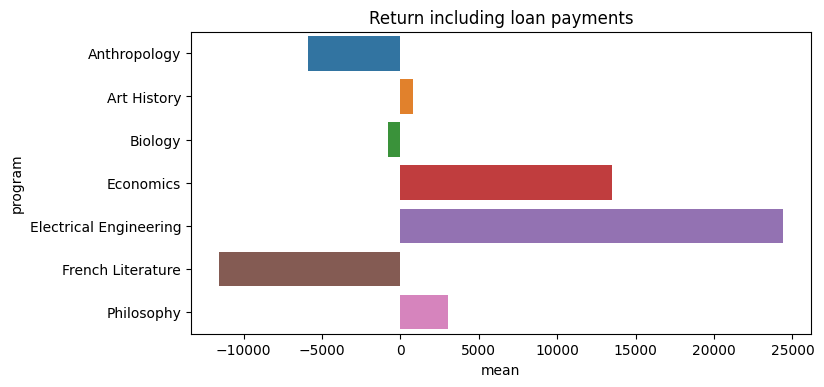

In [55]:
sns.barplot(x="mean", y="program", data=summary_w_payments).set_title("Return including loan payments")

__High school baselines__

In [56]:
cps = surveys.CPS_Ops()

/Users/mattlerner/roi/sbir-roi/roi/utilities.py:135: UserWarning: State codes, though integers, should be passed as strings. Something else was passed. Attempting to coerce to string.
  warnings.warn("State codes, though integers, should be passed as strings. Something else was passed. Attempting to coerce to string.")


In [57]:
cps.rudimentary_hs_baseline('08', [1, 5, 10])

[15017.630256967966, 21688.246894625805, 34336.28062777556]

In [58]:
{'year1': 15017.630256967966,
 'year5': 21688.246894625805,
 'year10': 34336.28062777556}

{'year1': 15017.630256967966,
 'year5': 21688.246894625805,
 'year10': 34336.28062777556}

In [59]:
states = ['CA','TX','AK','MS','CO']
fips = utilities.State_To_FIPS_series(states)

State_To_FIPS_series usually takes a pandas series. Something else was passed. Now trying under assumption that passed object is list or array


In [60]:
fips

['06', '48', '02', '28', '08']

In [61]:
baselines = pd.DataFrame([cps.rudimentary_hs_baseline(state, [1, 5, 10]) for state in fips])
baselines['state'] = states
baselines.columns = ['1','5','10','State']

In [62]:
baselines_melted = pd.melt(baselines, id_vars=['State'], var_name="year", value_name="earnings")
baselines_melted['year'] = baselines_melted['year'].astype(int)
baselines_melted['earnings'] = baselines_melted['earnings'].astype(int)

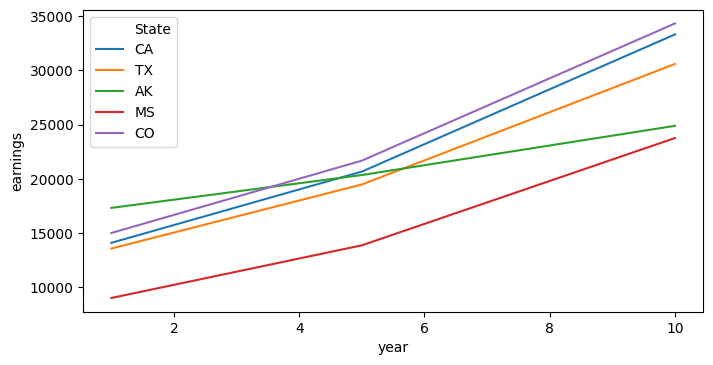

In [63]:
sns.lineplot(data=baselines_melted, x="year", y="earnings", hue="State")

__Completion rate vs earnings premium__

In [71]:
merged_rate_premium = completion_rate.merge(premium, on="program")

[Text(0, 0.5, 'Increased likelihood of employment'),
 Text(0.5, 0, 'Completion rate'),
 Text(0.5, 1.0, 'Completion rate vs employment premium')]

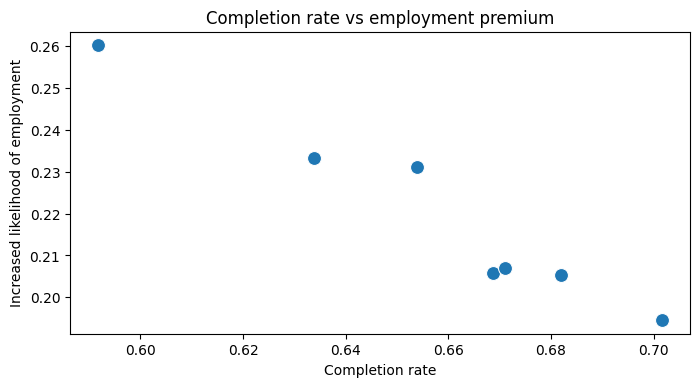

In [77]:
fig, ax = plt.subplots()
sns.scatterplot(data=merged_rate_premium, x="mean", y="mean_employment_premium", ax=ax, s=100)
ax.set(xlabel='Completion rate', ylabel='Increased likelihood of employment', title='Completion rate vs employment premium')